In [24]:
import cv2
import numpy as np
from scipy import ndimage
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K
import os
from keras.utils import to_categorical

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# pick 10 random fruits based on their containing folders in the training data
n_fruits = 10 
prediction_fruits = np.random.choice(os.listdir('fruits-360/Training/'), n_fruits)
# alternately - load fruits from a prior random model run
#prediction_fruits = np.load('model_fruits.npy')

In [3]:
# compile the file paths to all of the training/testing images for each type of fruit
train_img_urls = []
train_prefix = 'fruits-360/Training/%s/'
for i in prediction_fruits:
    train_fruit_urls = [(train_prefix % i) + j for j in os.listdir(train_prefix % i)]
    train_img_urls += train_fruit_urls 

In [4]:
# read in the images as BGR (OpenCV does this instead of RGB for some reason) data 
train_images = np.stack([cv2.imread(i, 1) for i in train_img_urls])

In [5]:
print(train_images.shape)

(5093, 100, 100, 3)


In [6]:
latent_dim = 100

In [46]:
class WGAN():
    def __init__(self):
        self.img_rows = 100
        self.img_cols = 100
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 25 * 25, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((25, 25, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, sample_interval=50):

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):
            print(epoch)
            for _ in range(self.n_critic):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("sample_images/fruits_%d.png" % epoch)
        plt.close()

In [47]:
test_gan = WGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 50, 50, 16)        448       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 26, 26, 32)        0         
__________

In [48]:
test_gan.train(epochs=1000,X_train=train_images, batch_size=100)

0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999791] [G loss: 1.000394]
1
1 [D loss: 0.999836] [G loss: 1.000405]
2
2 [D loss: 0.999852] [G loss: 1.000375]
3
3 [D loss: 0.999866] [G loss: 1.000348]
4
4 [D loss: 0.999865] [G loss: 1.000364]
5
5 [D loss: 0.999867] [G loss: 1.000349]
6
6 [D loss: 0.999871] [G loss: 1.000336]
7
7 [D loss: 0.999871] [G loss: 1.000340]
8
8 [D loss: 0.999881] [G loss: 1.000333]
9
9 [D loss: 0.999876] [G loss: 1.000318]
10
10 [D loss: 0.999893] [G loss: 1.000300]
11
11 [D loss: 0.999901] [G loss: 1.000258]
12
12 [D loss: 0.999910] [G loss: 1.000226]
13
13 [D loss: 0.999927] [G loss: 1.000186]
14
14 [D loss: 0.999949] [G loss: 1.000170]
15
15 [D loss: 0.999980] [G loss: 1.000125]
16
16 [D loss: 1.000017] [G loss: 1.000084]
17
17 [D loss: 1.000081] [G loss: 1.000039]
18
18 [D loss: 1.000180] [G loss: 0.999977]
19
19 [D loss: 1.000314] [G loss: 0.999924]
20
20 [D loss: 1.000510] [G loss: 0.999872]
21
21 [D loss: 1.000772] [G loss: 0.999784]
22
22 [D loss: 1.001129] [G loss: 0.999653]
23
23 [D l

183 [D loss: 1.484406] [G loss: 0.877687]
184
184 [D loss: 1.486513] [G loss: 0.883677]
185
185 [D loss: 1.481478] [G loss: 0.883094]
186
186 [D loss: 1.489029] [G loss: 0.874397]
187
187 [D loss: 1.487803] [G loss: 0.879700]
188
188 [D loss: 1.488603] [G loss: 0.886708]
189
189 [D loss: 1.490084] [G loss: 0.881490]
190
190 [D loss: 1.488133] [G loss: 0.883827]
191
191 [D loss: 1.490330] [G loss: 0.880395]
192
192 [D loss: 1.498560] [G loss: 0.888721]
193
193 [D loss: 1.493215] [G loss: 0.881139]
194
194 [D loss: 1.495416] [G loss: 0.890872]
195
195 [D loss: 1.498351] [G loss: 0.887394]
196
196 [D loss: 1.488161] [G loss: 0.889678]
197
197 [D loss: 1.490429] [G loss: 0.888032]
198
198 [D loss: 1.502134] [G loss: 0.882038]
199
199 [D loss: 1.485118] [G loss: 0.887130]
200
200 [D loss: 1.497785] [G loss: 0.885692]
201
201 [D loss: 1.499918] [G loss: 0.889996]
202
202 [D loss: 1.461974] [G loss: 0.889476]
203
203 [D loss: 1.506848] [G loss: 0.893471]
204
204 [D loss: 1.495593] [G loss: 0.

362 [D loss: 1.529531] [G loss: 0.907435]
363
363 [D loss: 1.521709] [G loss: 0.910053]
364
364 [D loss: 1.521049] [G loss: 0.905972]
365
365 [D loss: 1.518668] [G loss: 0.905507]
366
366 [D loss: 1.522538] [G loss: 0.907763]
367
367 [D loss: 1.511347] [G loss: 0.909417]
368
368 [D loss: 1.524157] [G loss: 0.909220]
369
369 [D loss: 1.530074] [G loss: 0.911249]
370
370 [D loss: 1.518805] [G loss: 0.913792]
371
371 [D loss: 1.518677] [G loss: 0.910585]
372
372 [D loss: 1.526395] [G loss: 0.907700]
373
373 [D loss: 1.523107] [G loss: 0.910785]
374
374 [D loss: 1.528219] [G loss: 0.909715]
375
375 [D loss: 1.520847] [G loss: 0.915033]
376
376 [D loss: 1.527279] [G loss: 0.913048]
377
377 [D loss: 1.521929] [G loss: 0.910072]
378
378 [D loss: 1.523133] [G loss: 0.909903]
379
379 [D loss: 1.498521] [G loss: 0.912811]
380
380 [D loss: 1.517140] [G loss: 0.908548]
381
381 [D loss: 1.529938] [G loss: 0.907750]
382
382 [D loss: 1.497900] [G loss: 0.912913]
383
383 [D loss: 1.527134] [G loss: 0.

541 [D loss: 1.519259] [G loss: 0.909763]
542
542 [D loss: 1.528991] [G loss: 0.906097]
543
543 [D loss: 1.536115] [G loss: 0.905782]
544
544 [D loss: 1.537901] [G loss: 0.906507]
545
545 [D loss: 1.547555] [G loss: 0.905126]
546
546 [D loss: 1.537194] [G loss: 0.909912]
547
547 [D loss: 1.546989] [G loss: 0.906835]
548
548 [D loss: 1.525879] [G loss: 0.910294]
549
549 [D loss: 1.539116] [G loss: 0.905658]
550
550 [D loss: 1.530582] [G loss: 0.909283]
551
551 [D loss: 1.524605] [G loss: 0.906697]
552
552 [D loss: 1.538176] [G loss: 0.901442]
553
553 [D loss: 1.529495] [G loss: 0.910340]
554
554 [D loss: 1.533245] [G loss: 0.904927]
555
555 [D loss: 1.540522] [G loss: 0.900491]
556
556 [D loss: 1.547372] [G loss: 0.906226]
557
557 [D loss: 1.528179] [G loss: 0.909956]
558
558 [D loss: 1.527815] [G loss: 0.908002]
559
559 [D loss: 1.542284] [G loss: 0.909480]
560
560 [D loss: 1.501575] [G loss: 0.909059]
561
561 [D loss: 1.533386] [G loss: 0.906653]
562
562 [D loss: 1.536900] [G loss: 0.

720 [D loss: 1.542117] [G loss: 0.900542]
721
721 [D loss: 1.546783] [G loss: 0.897333]
722
722 [D loss: 1.529813] [G loss: 0.902067]
723
723 [D loss: 1.543342] [G loss: 0.901978]
724
724 [D loss: 1.547789] [G loss: 0.906041]
725
725 [D loss: 1.535117] [G loss: 0.904945]
726
726 [D loss: 1.541683] [G loss: 0.898164]
727
727 [D loss: 1.532805] [G loss: 0.904236]
728
728 [D loss: 1.545268] [G loss: 0.908174]
729
729 [D loss: 1.541052] [G loss: 0.903181]
730
730 [D loss: 1.529597] [G loss: 0.900211]
731
731 [D loss: 1.531171] [G loss: 0.904845]
732
732 [D loss: 1.543409] [G loss: 0.897587]
733
733 [D loss: 1.536802] [G loss: 0.902591]
734
734 [D loss: 1.513666] [G loss: 0.898804]
735
735 [D loss: 1.540789] [G loss: 0.900313]
736
736 [D loss: 1.534244] [G loss: 0.897356]
737
737 [D loss: 1.541937] [G loss: 0.903041]
738
738 [D loss: 1.524312] [G loss: 0.902087]
739
739 [D loss: 1.542842] [G loss: 0.898357]
740
740 [D loss: 1.545578] [G loss: 0.902184]
741
741 [D loss: 1.540161] [G loss: 0.

899 [D loss: 1.522365] [G loss: 0.900188]
900
900 [D loss: 1.551583] [G loss: 0.892460]
901
901 [D loss: 1.542463] [G loss: 0.897990]
902
902 [D loss: 1.546535] [G loss: 0.893504]
903
903 [D loss: 1.529743] [G loss: 0.899410]
904
904 [D loss: 1.550396] [G loss: 0.890426]
905
905 [D loss: 1.532329] [G loss: 0.899132]
906
906 [D loss: 1.545468] [G loss: 0.892645]
907
907 [D loss: 1.529946] [G loss: 0.893397]
908
908 [D loss: 1.542028] [G loss: 0.894800]
909
909 [D loss: 1.532792] [G loss: 0.887042]
910
910 [D loss: 1.541000] [G loss: 0.893883]
911
911 [D loss: 1.544224] [G loss: 0.891684]
912
912 [D loss: 1.547383] [G loss: 0.898107]
913
913 [D loss: 1.540034] [G loss: 0.894276]
914
914 [D loss: 1.531724] [G loss: 0.898827]
915
915 [D loss: 1.535412] [G loss: 0.896177]
916
916 [D loss: 1.546956] [G loss: 0.890186]
917
917 [D loss: 1.550942] [G loss: 0.897266]
918
918 [D loss: 1.553210] [G loss: 0.890430]
919
919 [D loss: 1.536860] [G loss: 0.898983]
920
920 [D loss: 1.542130] [G loss: 0.

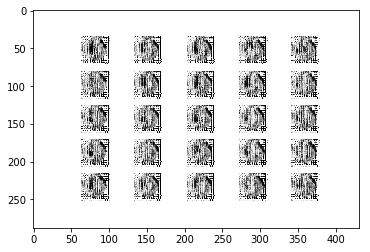

In [49]:
sample_img = plt.imread('sample_images/fruits_950.png')
plt.imshow(sample_img)